In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import re
from PIL import Image
import glob


import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import os
import sys
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *


#from tensorflow.keras.engine import Layer
from tensorflow.keras.applications.vgg16 import *
from tensorflow.keras.models import *
#from tensorflow.keras.applications.imagenet_utils import _obtain_input_shape
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Cropping2D, Conv2D
from tensorflow.keras.layers import Input, Add, Dropout, Permute, add
from tensorflow.compat.v1.layers import conv2d_transpose
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
print(tf.__version__)

2.3.0


In [3]:
x = tf.random.uniform([3, 3])

print("Is there a GPU available: "),
print(tf.config.list_physical_devices('GPU'))

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

print("Device name: {}".format((x.device)))

Is there a GPU available: 
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Is the Tensor on GPU #0:  
True
Device name: /job:localhost/replica:0/task:0/device:GPU:0


In [4]:
print(tf.executing_eagerly())
tf.compat.v1.enable_eager_execution()
tf.config.experimental_run_functions_eagerly(True) 
#tf.config.run_functions_eagerly(True)


True
Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [5]:
def _read_to_tensor(fname, output_height=256, output_width=256, normalize_data=False):
    '''Function to read images from given image file path, and provide resized images as tensors
        Inputs: 
            fname - image file path
            output_height - required output image height
            output_width - required output image width
            normalize_data - if True, normalize data to be centered around 0 (mean 0, range 0 to 1)
        Output: Processed image tensors
    '''
    
    # Read the image as a tensor
    img_strings = tf.io.read_file(fname)
    imgs_decoded = tf.image.decode_jpeg(img_strings)
    
    # Resize the image
    output = tf.image.resize(imgs_decoded, [output_height, output_width])
    
    # Normalize if required
    if normalize_data:
        output = (output - 128) / 128
    return output

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
img_dir = '/content/drive/My Drive/segmentation/image/'
masks_dir='/content/drive/My Drive/segmentation/masks/'

# Required image dimensions
output_height = 256
output_width = 256

In [8]:
os.remove('/content/drive/My Drive/segmentation/masks/S_385 (26)_0875 (1).png')
os.remove('/content/drive/My Drive/segmentation/masks/S_385 (26)_0876 (1).png')
os.remove('/content/drive/My Drive/segmentation/masks/S_385 (26)_0877 (1).png')
os.remove('/content/drive/My Drive/segmentation/masks/S_385 (26)_0878 (1).png')
os.remove('/content/drive/My Drive/segmentation/masks/S_385 (26)_0879 (1).png')
os.remove('/content/drive/My Drive/segmentation/masks/S_385 (26)_0880 (1).png')
os.remove('/content/drive/My Drive/segmentation/masks/S_385 (26)_0881 (1).png')
os.remove('/content/drive/My Drive/segmentation/masks/S_385 (26)_0882 (1).png')
os.remove('/content/drive/My Drive/segmentation/masks/S_385 (26)_0885 (1).png')
os.remove('/content/drive/My Drive/segmentation/masks/S_385 (26)_0886 (1).png')


FileNotFoundError: ignored

In [9]:
def read_images(img_dir,masks_dir):
    '''Function to get all image directories, read images and masks in separate tensors
        Inputs: 
            img_dir - image directory
            masks_dir- masks directory
        Outputs 
            image_tensors, masks_tensors, image files list, mask files list
    '''
    print('length of image dir',len(img_dir))
    print('length of masks dir',len(masks_dir))


    # Get the file names list from provided directory
    image_list = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]
    print('length of image un_sorted list',len(image_list))
    image_list=sorted(image_list)
    masks_list = [f for f in os.listdir(masks_dir) if os.path.isfile(os.path.join(masks_dir, f))]
    print('length of masks un_sorted list',len(masks_list))
    masks_list=sorted(masks_list)

    # Separate image and mask files lists, exclude unnecessary files
    #image_list = [file for file in image_list if ('.png' in file)] #and ('txt' not in file)]
    #masks_list = [file for file in masks_list if ('.png' in file)] #and ('txt' not in file)]
    
    print('{} image files found in the provided directory.'.format(len(image_list)))
    print('{} mask files found in the provided directory.'.format(len(masks_list)))
    
    # Create file paths from file names
    image_paths = [os.path.join(img_dir, fname) for fname in image_list]
    masks_paths = [os.path.join(masks_dir, fname) for fname in masks_list]
    
    # Create dataset of tensors
    image_data = tf.data.Dataset.from_tensor_slices(image_paths)
    masks_data = tf.data.Dataset.from_tensor_slices(masks_paths)
    
    # Read images into the tensor dataset
    image_tensors = image_data.map(_read_to_tensor)
    masks_tensors = masks_data.map(_read_to_tensor)
    
    print('Completed importing {} images from the provided directory.'.format(len(image_list)))
    print('Completed importing {} mask images from the provided directory.'.format(len(masks_list)))

    print(image_list)
    print(masks_list)
    
    return image_tensors, masks_tensors, image_list, masks_list

image_tensors, masks_tensors, image_list, masks_list = read_images(img_dir,masks_dir)

length of image dir 43
length of masks dir 43
length of image un_sorted list 6095
length of masks un_sorted list 6095
6095 image files found in the provided directory.
6095 mask files found in the provided directory.
Completed importing 6095 images from the provided directory.
Completed importing 6095 mask images from the provided directory.
['S_385 (19)_0024.png', 'S_385 (19)_0043.png', 'S_385 (19)_0044.png', 'S_385 (19)_0045.png', 'S_385 (19)_0046.png', 'S_385 (19)_0048.png', 'S_385 (19)_0066.png', 'S_385 (19)_0067.png', 'S_385 (19)_0070.png', 'S_385 (19)_0072.png', 'S_385 (19)_0088.png', 'S_385 (19)_0089.png', 'S_385 (19)_0090.png', 'S_385 (19)_0093.png', 'S_385 (19)_0094.png', 'S_385 (19)_0096.png', 'S_385 (19)_0111.png', 'S_385 (19)_0112.png', 'S_385 (19)_0113.png', 'S_385 (19)_0114.png', 'S_385 (19)_0117.png', 'S_385 (19)_0118.png', 'S_385 (19)_0120.png', 'S_385 (19)_0134.png', 'S_385 (19)_0135.png', 'S_385 (19)_0136.png', 'S_385 (19)_0137.png', 'S_385 (19)_0141.png', 'S_385 (19)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


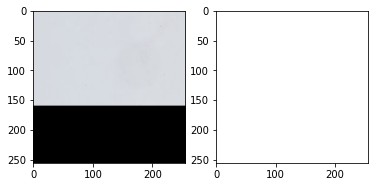

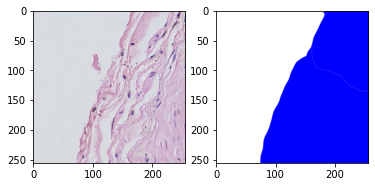

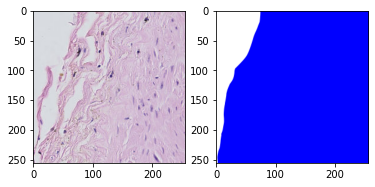

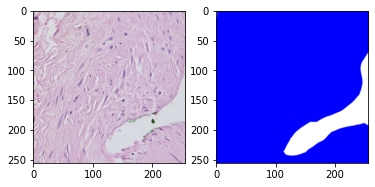

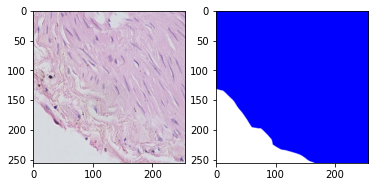

In [10]:
# Make an iterator to extract images from the tensor dataset
image_batches = tf.compat.v1.data.make_one_shot_iterator(image_tensors)  # outside of TF Eager, we would use make_one_shot_iterator
mask_batches = tf.compat.v1.data.make_one_shot_iterator(masks_tensors)

n_images_to_show = 5

for i in range(n_images_to_show):
    
    # Get the next image from iterator
    image = image_batches.next().numpy().astype(np.uint8)
    mask = mask_batches.next().numpy().astype(np.uint8)
    
    #Plot the corresponding image and masks
    fig = plt.figure()
    fig.add_subplot(1,2,1)
    plt.imshow(image)
    fig.add_subplot(1,2,2)
    plt.imshow(mask)
    plt.show()

In [11]:
DATA_PATH = '/content/drive/My Drive/segmentation/'

# Create folders to hold images and masks

folders = ['train_image/train', 'train_masks/train', 'val_image/val', 'val_masks/val']


for folder in folders:
    try:
        os.makedirs(DATA_PATH + folder)
    except Exception as e: print(e)

In [12]:
def generate_image_folder_structure(image, masks, image_list, masks_list):
    '''Function to save images in the appropriate folder directories 
        Inputs: 
            image - image tensor dataset
            masks - mask tensor dataset
            image_list - image file paths
            masks_list - mask file paths
    '''
    #Create iterators for image and masks
    image_batches = tf.compat.v1.data.make_one_shot_iterator(image)  # outside of TF Eager, we would use make_one_shot_iterator
    mask_batches = tf.compat.v1.data.make_one_shot_iterator(masks)
    
    #Iterate over the train images while saving the image and masks in appropriate folders
    dir_name='train'
    for file in zip(image_list[:-round(0.2*len(image_list))],masks_list[:-round(0.2*len(masks_list))]):
        
        
        #Convert tensors to numpy arrays
        image = image_batches.next().numpy().astype(np.uint8)
        mask = mask_batches.next().numpy().astype(np.uint8)
        
        #Convert numpy arrays to images
        image = Image.fromarray(image)
        mask = Image.fromarray(mask)
        
        #Save image and masks to correct directories
        image.save(DATA_PATH+'{}_image/{}'.format(dir_name,dir_name)+'/'+file[0])
        mask.save(DATA_PATH+'{}_masks/{}'.format(dir_name,dir_name)+'/'+file[1])

         #Iterate over the val images while saving the image and masks in appropriate folders
    dir_name='val'
    for file in zip(image_list[-round(0.2*len(image_list)):],masks_list[-round(0.2*len(masks_list)):]):
        
        
        #Convert tensors to numpy arrays
        image = image_batches.next().numpy().astype(np.uint8)
        mask = mask_batches.next().numpy().astype(np.uint8)
        
        #Convert numpy arrays to images
        image = Image.fromarray(image)
        mask = Image.fromarray(mask)
        
        #Save image and masks to correct directories
        image.save(DATA_PATH+'{}_image/{}'.format(dir_name,dir_name)+'/'+file[0])
        mask.save(DATA_PATH+'{}_masks/{}'.format(dir_name,dir_name)+'/'+file[1])
    
    print("Saved {} image to directory {}".format(len(image_list),DATA_PATH))
    print("Saved {} masks to directory {}".format(len(masks_list),DATA_PATH))
    
generate_image_folder_structure(image_tensors, masks_tensors, image_list, masks_list)

#generate_image_folder_structure(train_image, train_masks, val_files, 'val')

Saved 6095 image to directory /content/drive/My Drive/segmentation/
Saved 6095 masks to directory /content/drive/My Drive/segmentation/


In [13]:
label_codes=[(128,0,0),(128,0,128),(0,0,255),(0,128,0),(255,255,0),(255,105,180),(255,0,0),(255,165,0),(128,128,128),(255,255,255)]

In [14]:
label_names=['Dark_dense_distribution', 'Elongated_nuclei','Light_dense_istribution','Light_distribution',
           'No_nuclei_with_uniform_texture','No_nuclei_with_unstructured','Red_texture',  'Round_nuclei','Mixed','background']

In [15]:
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

In [16]:
name2id = {v:k for k,v in enumerate(label_names)}
id2name = {k:v for k,v in enumerate(label_names)}

In [17]:
id2code

{0: (128, 0, 0),
 1: (128, 0, 128),
 2: (0, 0, 255),
 3: (0, 128, 0),
 4: (255, 255, 0),
 5: (255, 105, 180),
 6: (255, 0, 0),
 7: (255, 165, 0),
 8: (128, 128, 128),
 9: (255, 255, 255)}

In [18]:
id2name

{0: 'Dark_dense_distribution',
 1: 'Elongated_nuclei',
 2: 'Light_dense_istribution',
 3: 'Light_distribution',
 4: 'No_nuclei_with_uniform_texture',
 5: 'No_nuclei_with_unstructured',
 6: 'Red_texture',
 7: 'Round_nuclei',
 8: 'Mixed',
 9: 'background'}

In [19]:
def rgb_to_onehot(rgb_image, colormap = id2code):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    #print('num_classes',num_classes)
    shape = rgb_image.shape[:2]+(num_classes,)
    #print('shape',shape)
    encoded_image = np.zeros( shape, dtype=np.float32)
    #print('encoded image',encoded_image)
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
        #print('looping encode',encoded_image)
    return encoded_image


def onehot_to_rgb(onehot, colormap = id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    #print(f'onehot to rgb{onehot}')
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.float32(output)

In [20]:
# Normalizing only images, since masks contain label info
data_gen_args = dict(rescale=1./255)
mask_gen_args = dict()

train_image_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**mask_gen_args)
val_image_datagen = ImageDataGenerator(**data_gen_args)
val_masks_datagen = ImageDataGenerator(**mask_gen_args)

# Seed defined for aligning images and their masks
seed = 1

In [21]:
def TrainAugmentGenerator(seed = 1, batch_size = 32):
    '''Train Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
        Output: Decoded RGB image (height x width x 3) 
    '''
    train_image_generator = train_image_datagen.flow_from_directory(
    DATA_PATH + 'train_image/',
    batch_size = batch_size, seed = seed)

    train_mask_generator = train_masks_datagen.flow_from_directory(
    DATA_PATH + 'train_masks/',
    batch_size = batch_size, seed = seed)

    while True:
        X1i = train_image_generator.next()
        X2i = train_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)
        

def ValAugmentGenerator(seed = 1, batch_size = 16):
    '''Validation Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
        Output: Decoded RGB image (height x width x 3) 
    '''
    val_image_generator = val_image_datagen.flow_from_directory(
    DATA_PATH + 'val_image/',
    batch_size = batch_size, seed = seed)


    val_mask_generator = val_masks_datagen.flow_from_directory(
    DATA_PATH + 'val_masks/',
    batch_size = batch_size, seed = seed)


    while True:
        X1i = val_image_generator.next()
        X2i = val_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)



In [22]:
def get_small_unet(n_filters = 32, bn = True, dilation_rate = 1):
    '''Validation Image data generator
        Inputs: 
            n_filters - base convolution filters
            bn - flag to set batch normalization
            dilation_rate - convolution dilation rate
        Output: Unet keras Model
    '''
    #Define input batch shape
    batch_shape=(256,256,3)
    inputs = Input(batch_shape=(32, 256, 256, 3))
    print(inputs)
    
    conv1 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(inputs)
    if bn:
        conv1 = BatchNormalization()(conv1)
        
    conv1 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv1)
    if bn:
        conv1 = BatchNormalization()(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv1)

    conv2 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool1)
    if bn:
        conv2 = BatchNormalization()(conv2)
        
    conv2 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv2)
    if bn:
        conv2 = BatchNormalization()(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv2)

    conv3 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool2)
    if bn:
        conv3 = BatchNormalization()(conv3)
        
    conv3 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv3)
    if bn:
        conv3 = BatchNormalization()(conv3)
        
    pool3 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv3)

    conv4 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool3)
    if bn:
        conv4 = BatchNormalization()(conv4)
        
    conv4 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv4)
    if bn:
        conv4 = BatchNormalization()(conv4)
        
    pool4 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv4)

    conv5 = Conv2D(n_filters * 16, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool4)
    if bn:
        conv5 = BatchNormalization()(conv5)

    conv5 = Conv2D(n_filters * 16, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv5)
    if bn:
        conv5 = BatchNormalization()(conv5)
        
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    
    conv6 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up6)
    if bn:
        conv6 = BatchNormalization()(conv6)
        
    conv6 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv6)
    if bn:
        conv6 = BatchNormalization()(conv6)
        
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    
    conv7 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up7)
    if bn:
        conv7 = BatchNormalization()(conv7)
        
    conv7 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv7)
    if bn:
        conv7 = BatchNormalization()(conv7)
        
    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    
    conv8 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up8)
    if bn:
        conv8 = BatchNormalization()(conv8)
        
    conv8 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv8)
    if bn:
        conv8 = BatchNormalization()(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    
    conv9 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up9)
    if bn:
        conv9 = BatchNormalization()(conv9)
        
    conv9 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv9)
    if bn:
        conv9 = BatchNormalization()(conv9)
        
    conv10 = Conv2D(10, (1, 1), activation='softmax', padding = 'same', dilation_rate = dilation_rate)(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    
    return model

In [23]:
model = get_small_unet(n_filters = 10)

Tensor("input_1:0", shape=(32, 256, 256, 3), dtype=float32)


In [24]:
# Ref: salehi17, "Twersky loss function for image segmentation using 3D FCDN"
# -> the score is computed for each class separately and then summed
# alpha=beta=0.5 : dice coefficient
# alpha=beta=1   : tanimoto coefficient (also known as jaccard)
# alpha+beta=1   : produces set of F*-scores
# implemented by E. Moebel, 06/04/18
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2,3))
    den = num + alpha*K.sum(p0*g1,(0,1,2,3)) + beta*K.sum(p1*g0,(0,1,2,3))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

In [25]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

In [26]:
smooth = 1.


In [27]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tversky_loss,dice_coef,'accuracy'])

In [28]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(32, 256, 256, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (32, 256, 256, 10)   280         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (32, 256, 256, 10)   40          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (32, 256, 256, 10)   910         batch_normalization[0][0]        
_______________________________________________________________________________________

In [29]:
tb = TensorBoard(log_dir='logs', write_graph=True)
mc = ModelCheckpoint(mode='max', filepath='/content/drive/My Drive/segmentation/segmentation_model_50_val_04th_WITH_epochs_checkpoint.h5', monitor='accuracy', save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='val_dice_coef', patience=20, verbose=1)
callbacks = [tb, mc, es]

In [30]:
batch_size = 32
steps_per_epoch = np.ceil(float(len(image_list) - round(0.1*len(image_list))) / float(batch_size))
steps_per_epoch

172.0

In [31]:
validation_steps = (float((round(0.1*len(image_list)))) / float(batch_size))
validation_steps

19.0625

In [32]:
num_epochs = 50

In [33]:
#model.load_weights("/content/drive/My Drive/Segmentation/segmentation_model_50_epochs.h5")
#loss,acc = model.evaluate(test_images,  test_labels, verbose=2)



In [34]:
# experimental_run_tf_function=False
# tf.compat.v1.enable_eager_execution() 


In [35]:
# Train model

batch_size = 32
result = model.fit(TrainAugmentGenerator(), steps_per_epoch=steps_per_epoch,
                validation_data = ValAugmentGenerator(), validation_steps = 4 ,epochs=num_epochs, 
                 callbacks=callbacks)
model.save_weights("/content/drive/My Drive/segmentation/segmentation_model_50_val_04th_with_epochs.h5", overwrite=True)

Found 4876 images belonging to 1 classes.
Found 4876 images belonging to 1 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/50
  1/172 [..............................] - ETA: 0s - loss: 2.3362 - tversky_loss: 9.9045 - dice_coef: 0.1709 - accuracy: 0.1216WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
172/172 [==============================] - ETA: 0s - loss: 0.9268 - tversky_loss: 9.5476 - dice_coef: 0.6744 - accuracy: 0.6067Found 1219 images belonging to 1 classes.
Found 1219 images belonging to 1 classes.

Epoch 00001: accuracy improved from -inf to 0.60670, saving model to /content/drive/My Drive/segmentation/segmentation_model_50_val_04th_WITH_epochs_checkpoint.h5
172/172 [==============================] - 159s 927ms/step - loss: 0.9268 - tversky_loss: 9.5476 - dice_coef: 0.6744 - accuracy: 0.6067 - val_loss: 1.1627 - val_tversky_loss: 9.5060 - val_dice_coef: 0.6796 - v

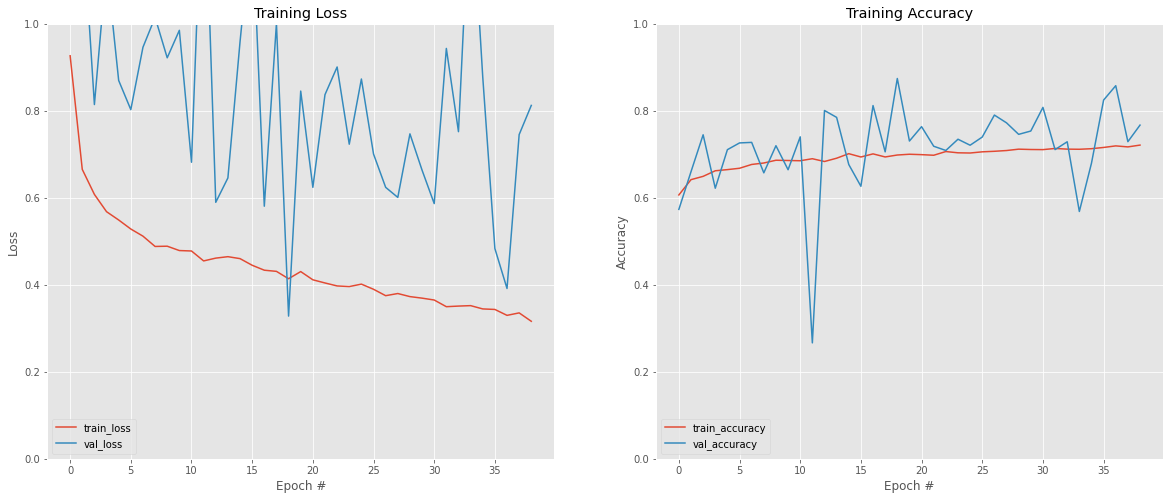

In [36]:
# Get actual number of epochs model was trained for
N = len(result.history['loss'])

#Plot the model evaluation history
plt.style.use("ggplot")
fig = plt.figure(figsize=(20,8))

fig.add_subplot(1,2,1)
plt.title("Training Loss")
plt.plot(np.arange(0, N), result.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), result.history["val_loss"], label="val_loss")
plt.ylim(0, 1)

plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

fig.add_subplot(1,2,2)
plt.title("Training Accuracy")
plt.plot(np.arange(0, N), result.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), result.history["val_accuracy"], label="val_accuracy")
plt.ylim(0, 1)

plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()

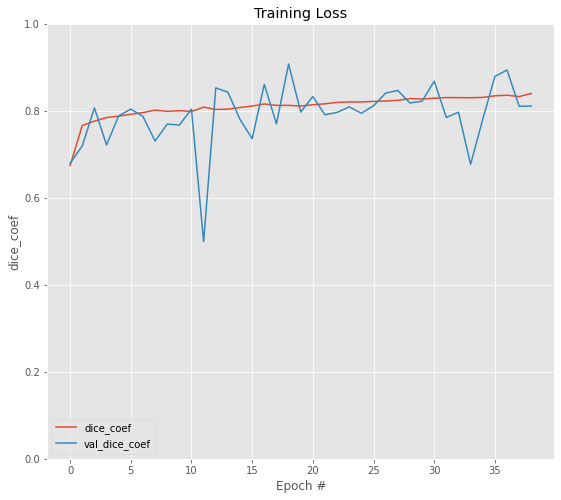

In [37]:
# Get actual number of epochs model was trained for
N = len(result.history['dice_coef'])

#Plot the model evaluation history
plt.style.use("ggplot")
fig = plt.figure(figsize=(20,8))

fig.add_subplot(1,2,1)
plt.title("Training Loss")
plt.plot(np.arange(0, N), result.history["dice_coef"], label="dice_coef")
plt.plot(np.arange(0, N), result.history["val_dice_coef"], label="val_dice_coef")
plt.ylim(0, 1)

plt.xlabel("Epoch #")
plt.ylabel("dice_coef")
plt.legend(loc="lower left")
plt.show()
# fig.add_subplot(1,2,2)
# plt.title("Training Accuracy")
# plt.plot(np.arange(0, N), result.history["accuracy"], label="train_accuracy")
# plt.plot(np.arange(0, N), result.history["val_accuracy"], label="val_accuracy")
# plt.ylim(0, 1)

# plt.xlabel("Epoch #")
# plt.ylabel("Loss/Accuracy")
# plt.legend(loc="lower left")
# plt.show()

In [38]:
#training_gen = TrainAugmentGenerator()
testing_gen = ValAugmentGenerator()

In [39]:
# test_eval = model.evaluate_generator(testing_gen,steps = len(testing_gen), verbose=1)
# test_generator.reset()

In [40]:
batch_img,batch_mask = next(testing_gen)
#batch_img,batch_mask = next(training_gen)
pred_all= model.predict(batch_img)
#print(batch_mask)
np.shape(pred_all)


Found 1219 images belonging to 1 classes.
Found 1219 images belonging to 1 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


(16, 256, 256, 10)

In [ ]:
acc = model.evaluate(batch_img, batch_mask, verbose=2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


1/1 - 0s - loss: 0.2368 - tversky_loss: 9.3598 - dice_coef: 0.8105 - accuracy: 0.5842


ValueError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


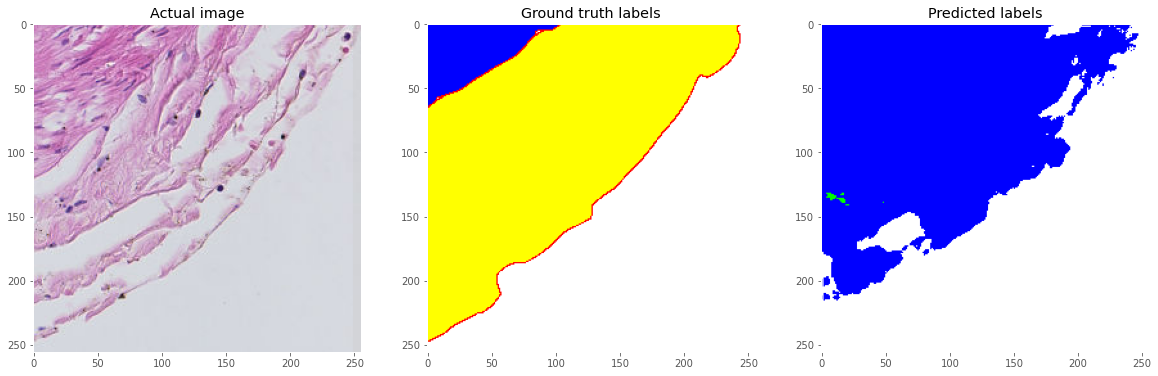

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


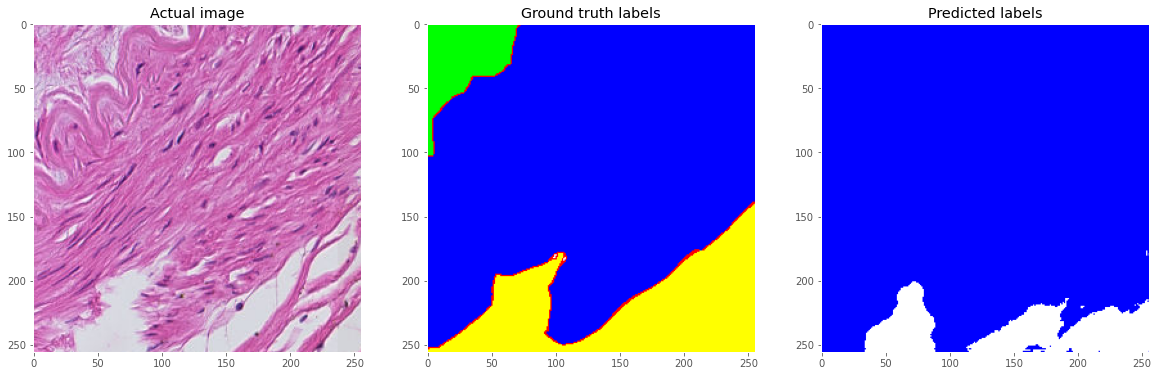

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


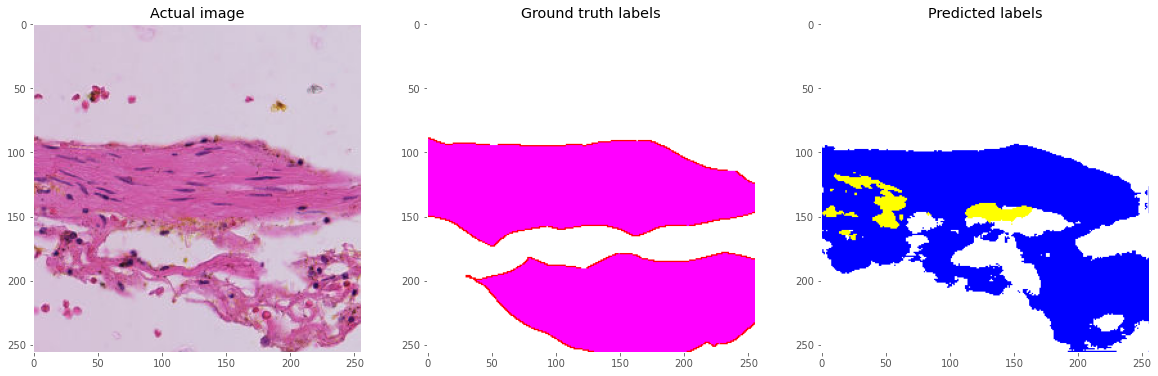

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


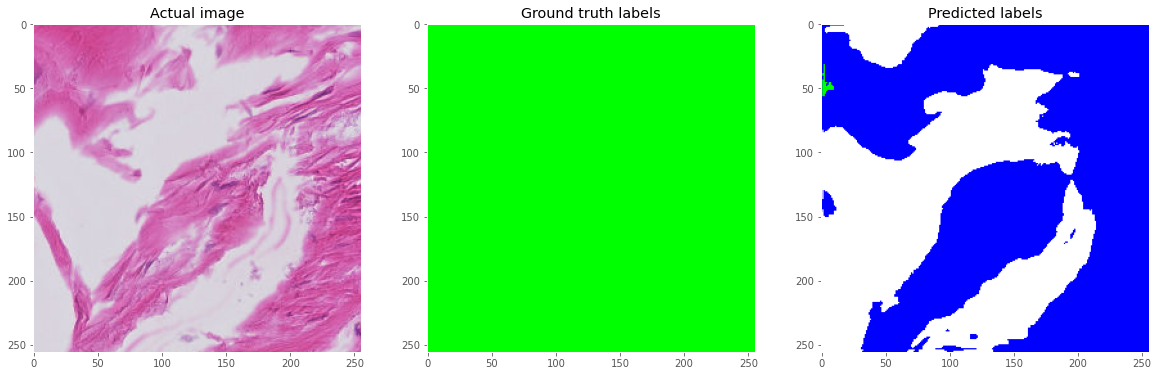

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


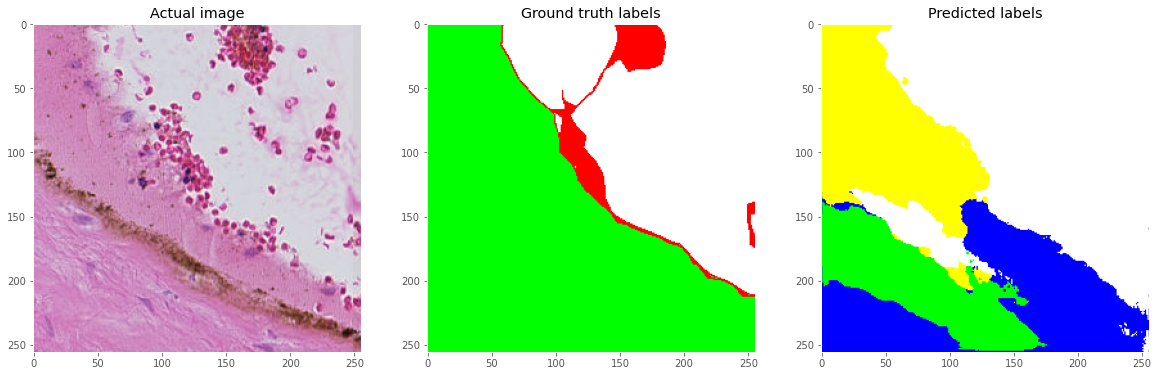

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


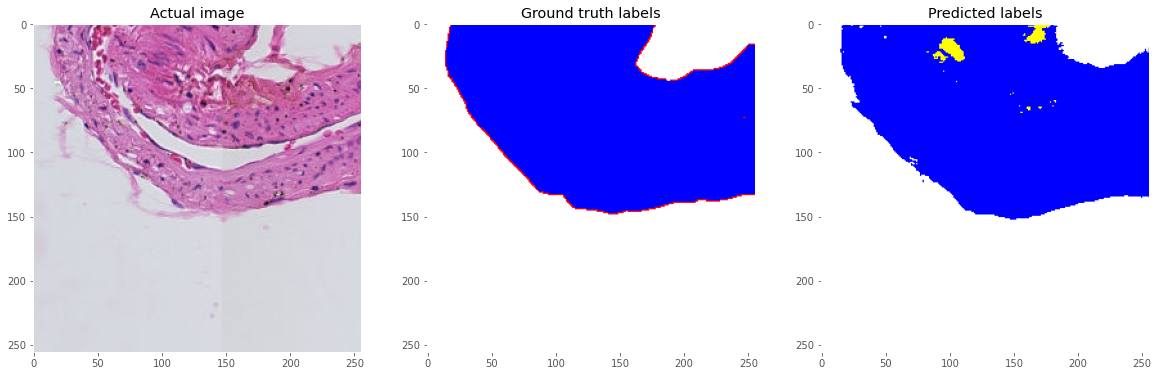

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


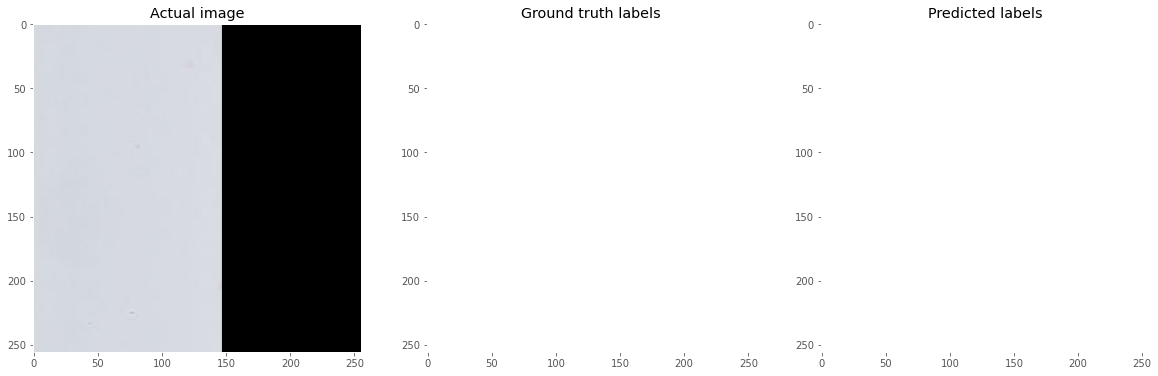

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


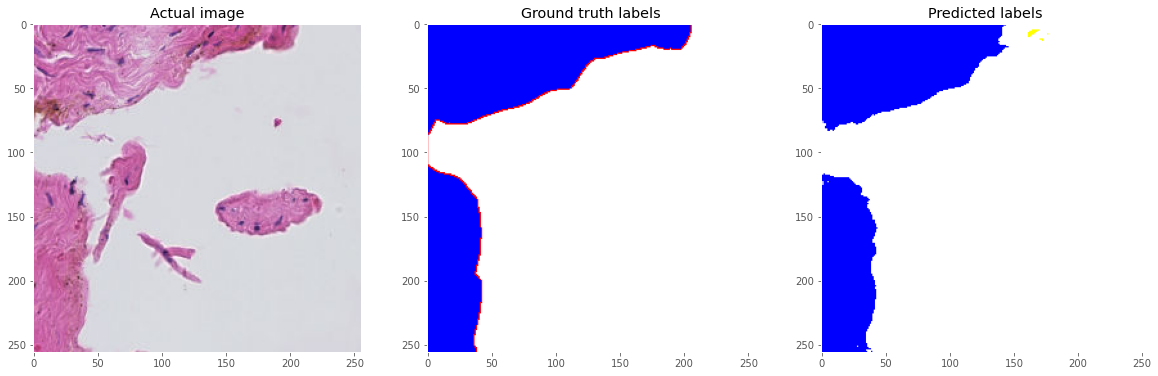

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


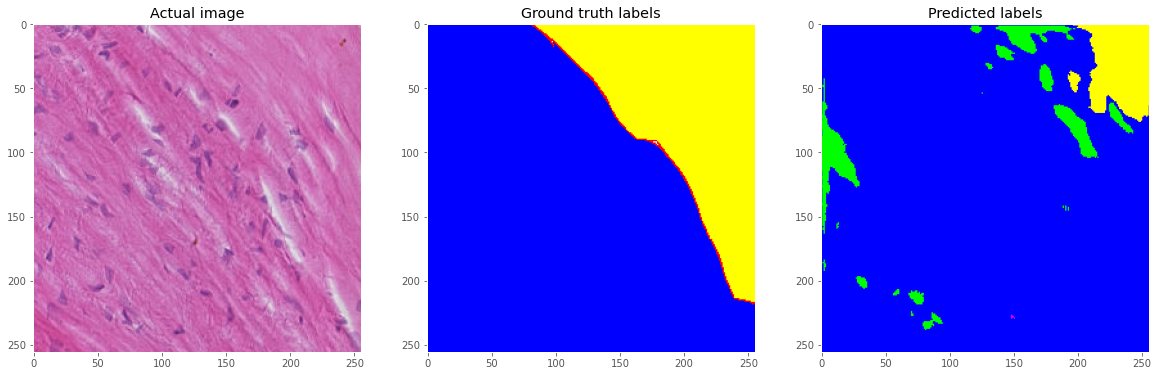

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


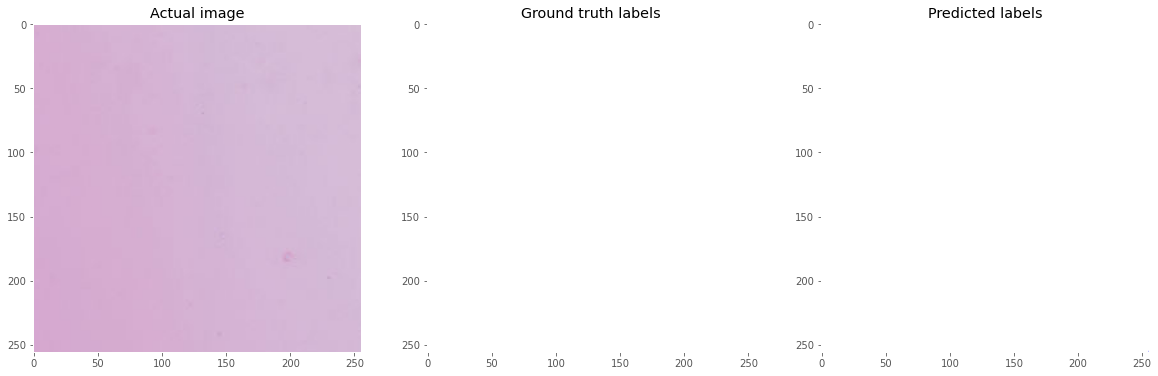

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


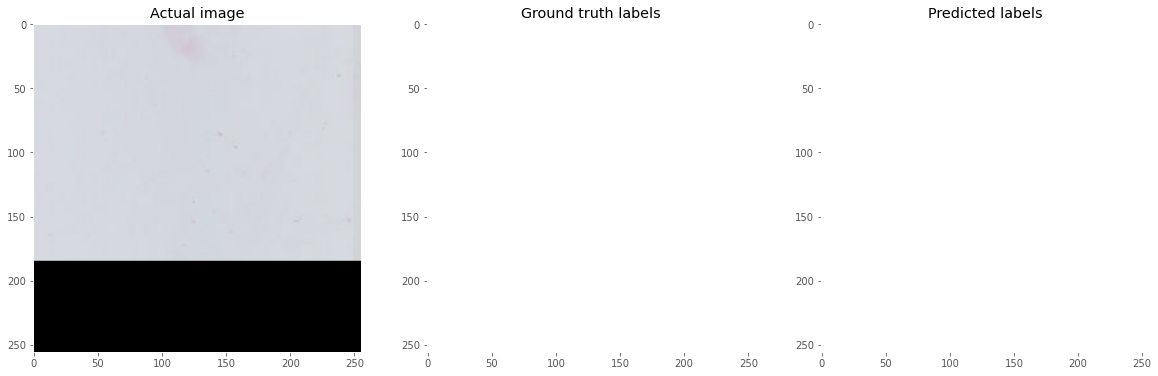

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


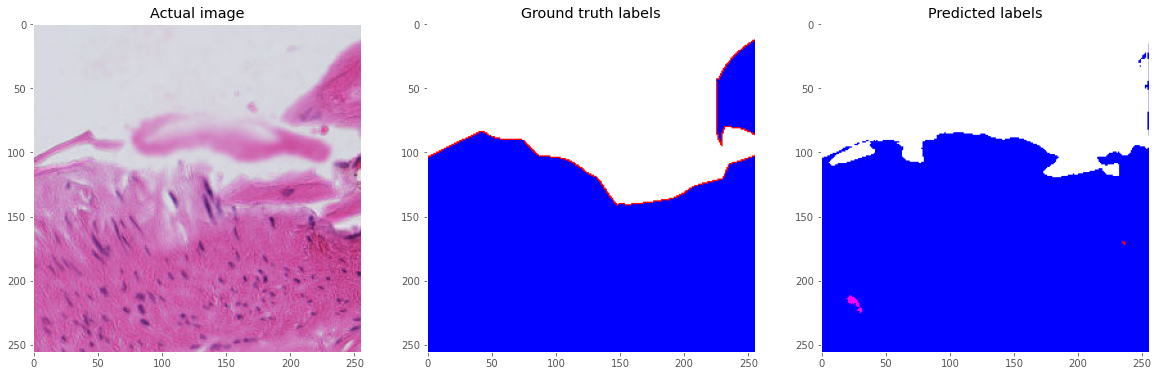

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


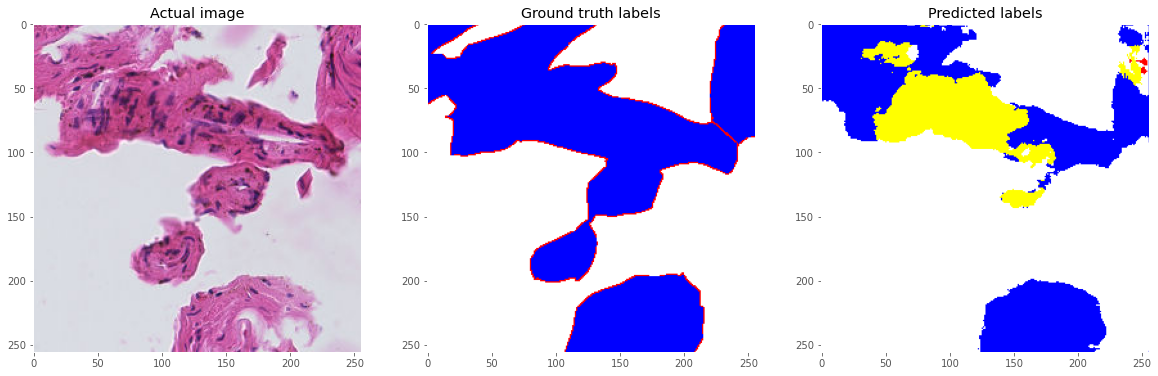

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


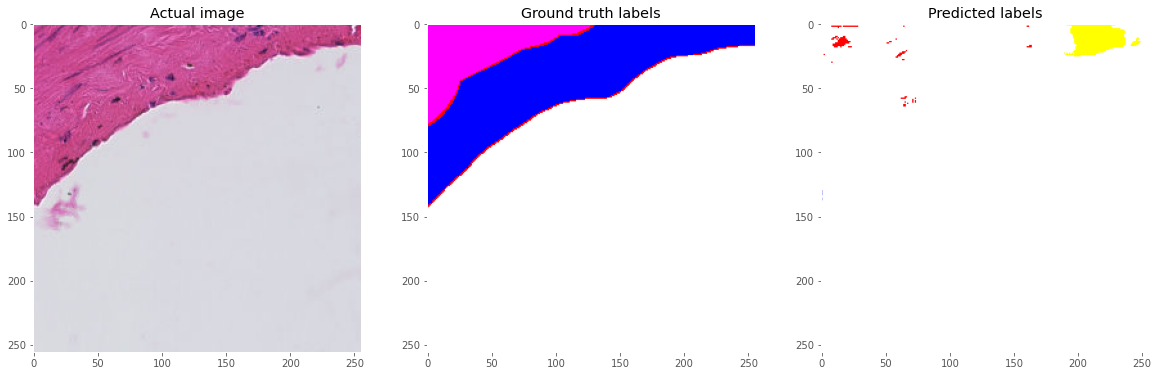

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


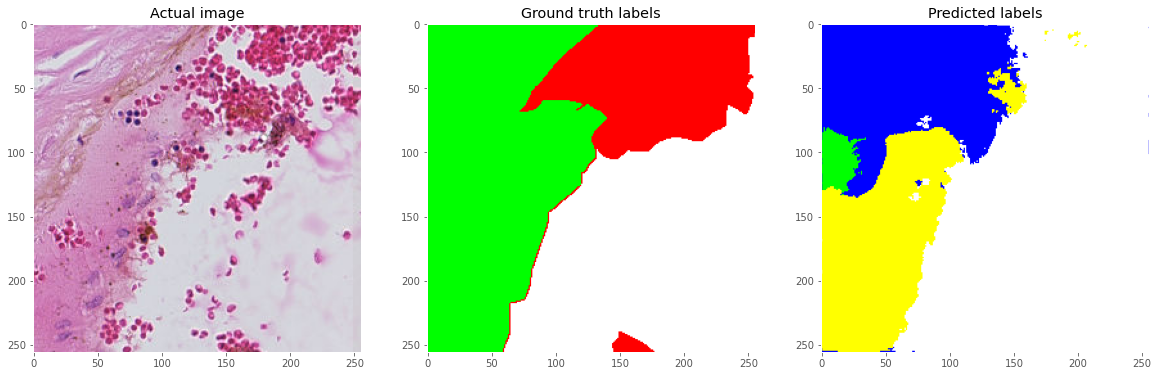

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


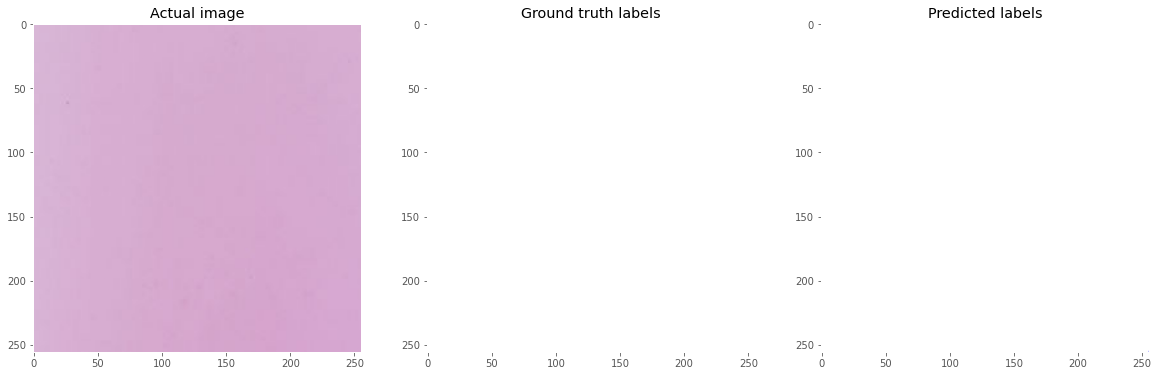

In [41]:
for i in range(0,np.shape(pred_all)[0]):
    
    fig = plt.figure(figsize=(20,8))
    
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(batch_img[i])
    ax1.title.set_text('Actual image')
    ax1.grid(b=None)
    
    
    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Ground truth labels')
    ax2.imshow(onehot_to_rgb(batch_mask[i],id2code))
    #ax2.imshow()
    ax2.grid(b=None)
    
    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('Predicted labels')
    ax3.imshow(onehot_to_rgb(pred_all[i],id2code))
    ax3.grid(b=None)
    
    plt.show()

In [ ]:
tf.compat.v1.enable_eager_execution() 


In [42]:
acc = model.evaluate(batch_img, batch_mask, verbose=2)


1/1 - 0s - loss: 1.0521 - tversky_loss: 9.3208 - dice_coef: 0.7748 - accuracy: 0.7371


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [ ]:
'''latest good results
43/43 [==============================] - ETA: 0s - loss: 0.2861 - tversky_loss: 9.2378 - dice_coef: 0.8718 - accuracy: 0.7566
Epoch 00050: accuracy improved from 0.75591 to 0.75656, saving model to /content/drive/My Drive/segmentation/segmentation_model_50_with_norm_epochs_checkpoint.h5
43/43 [==============================] - 56s 1s/step - loss: 0.2861 - tversky_loss: 9.2378 - dice_coef: 0.8718 - accuracy: 0.7566 - val_loss: 0.6213 - val_tversky_loss: 9.3738 - val_dice_coef: 0.7534 - val_accuracy: 0.5767


test
loss: 0.1370 - tversky_loss: 9.2932 - dice_coef: 0.8461 - accuracy: 0.6068

'''
